<h2> Infrastructure </h2>

In [ ]:
# Tips

# Jupyter: 
#    [View->Table of contents] for an outline of the headings
#    You can click to the left of headings to collapse/expand their section
# VSCode:
#    Outline button in row above
#    Click on blue bar to the left of a cell or its output to hide them
# Both:
#    Select multiple lines of code, then press [ctrl+/] to comment or uncomment all

<h3> Import Libraries </h3>

In [6]:
# Initialization code for PMOS_LDO
# Written by Shawn Newman (with a lot of code from Langdon Skarda)

import pyvisa                    # Instrument communication
import time                      # Handle time-related tasks (e.g., delays)
import matplotlib.pyplot as plt  # Plotting graphs and visualizing data
import numpy as np               # Numerical operations, particularly with arrays
import pandas as pd              # Data manipulation and analysis
import os                        # Interact with the operating system, such as handling file paths
import csv                       # Read from and write to CSV files
from datetime import date        # Read current date
from collections import defaultdict

<h3> Useful Functions </h3>

In [7]:
# Determine the appropriate scaling for generated plots in Engineering Notation
def scale(list):
    array = np.asarray(list, dtype='float') # Python's lists don't support multiplication by a float. Numpy's arrays do.
    if np.max(np.abs(array)) < 1e-12:
        print("Not implemented")
        return -1
    elif np.max(np.abs(array)) < 1e-9:
        k = 1e12
    elif np.max(np.abs(array)) < 1e-6:
        k = 1e9
    elif np.max(np.abs(array)) < 1e-3:
        k = 1e6
    elif np.max(np.abs(array)) < 1:
        k = 1e3
    elif np.max(np.abs(array)) < 1e3:
        k = 1
    else:
        print("Not implemented")
        return -1
    
    return k*array # Return the scaled array

# Determine the appropriate prefix for arrays that use scale(). 
# PASS THE ORIGINAL LIST, NOT THE SCALED
def prefix(list):
    array = np.asarray(list, dtype='float')
    if np.max(np.abs(array)) < 1e-12:
        print("Not implemented")
        return -1
    elif np.max(np.abs(array)) < 1e-9:
        k = 1e12
        prefix = 'p'
    elif np.max(np.abs(array)) < 1e-6:
        k = 1e9
        prefix = 'n'
    elif np.max(np.abs(array)) < 1e-3:
        k = 1e6
        prefix = 'µ'
    elif np.max(np.abs(array)) < 1:
        k = 1e3
        prefix = 'm'
    elif np.max(np.abs(array)) < 1e3:
        k = 1
    else:
        print("Not implemented")
        return -1

    return prefix

# Determines and returns the highest precision of all elements in a list
def determine_precision(list):
    list = [round(float(element), 13) for element in list]
    precisions = []
    for element in list:
        element_str = str(element).rstrip('0') # Removes trailing zeros
        if '.' in element_str:
            precisions.append(len(element_str.split('.')[1])) # Number of digits after '.'
        else:
            precisions.append(0)
    return max(precisions)

# Determines the highest precision of all elements in a list, returns specified element as a string with that precision. Adds trailing zeros.
# This should avoid poorly sorted or inconsistent file names.
def set_precision(imprecise_element, list):
    imprecise_element = float(imprecise_element)
    return f"{imprecise_element:.{determine_precision(list)}f}"

<h3> Constants </h3>

In [9]:
DEVICE_NAME = "PMOS_LDO" # Global directory
SET_PRECISION = .15 # This determines how close the probe's temperature needs to get to the SET value before soak time begins 

# Circuit Values
Rhi = 264.3
Rlo = 68000

# Desired Values (used for calcs)
IL_default = .003
VREF_default = .8

#Sweeps
VIN_MAX = 1.8
VIN_STEP = -.025
VIN_MIN = 1
# Full VIN list isn't created until the tests, since the minimum value will change.
VIN_example_list = np.arange(VIN_MAX, VIN_MIN+VIN_STEP, VIN_STEP)
VIN_example_list = [round(VIN, 10) for VIN in VIN_example_list]
print(f"VIN: {VIN_example_list}")

VREF_MAX = .85
VREF_STEP = -.05
VREF_MIN = .3
Global_VREFs_unrounded = np.arange(VREF_MAX, VREF_MIN+VREF_STEP, VREF_STEP) # Adding the step to the second argument will include its value in the sweep.
Global_VREFs = [round(VREF, 10) for VREF in Global_VREFs_unrounded] #If you don't round after arange() it'll display the floats with the precision they're stored with. i.e. 2 -> 1.99999999999999995
print(f"VREF: {Global_VREFs}")
VREF_precision = determine_precision(Global_VREFs)
print(f"Precision: {VREF_precision}")

temp_list = [125, 100, 75, 50, 25,  0, -25, -50, -75, -100, -125, -150, -175]

ILlist = [100E-6, 300E-6, 500E-6, 1E-3, 2E-3, 3E-3, 4E-3, 5E-3, 6E-3, 7E-3, 8E-3, 9E-3, 10E-3]
ILlistmA = scale(ILlist)
print(ILlistmA)

VIN: [np.float64(1.8), np.float64(1.775), np.float64(1.75), np.float64(1.725), np.float64(1.7), np.float64(1.675), np.float64(1.65), np.float64(1.625), np.float64(1.6), np.float64(1.575), np.float64(1.55), np.float64(1.525), np.float64(1.5), np.float64(1.475), np.float64(1.45), np.float64(1.425), np.float64(1.4), np.float64(1.375), np.float64(1.35), np.float64(1.325), np.float64(1.3), np.float64(1.275), np.float64(1.25), np.float64(1.225), np.float64(1.2), np.float64(1.175), np.float64(1.15), np.float64(1.125), np.float64(1.1), np.float64(1.075), np.float64(1.05), np.float64(1.025), np.float64(1.0)]
VREF: [np.float64(0.85), np.float64(0.8), np.float64(0.75), np.float64(0.7), np.float64(0.65), np.float64(0.6), np.float64(0.55), np.float64(0.5), np.float64(0.45), np.float64(0.4), np.float64(0.35), np.float64(0.3)]
Precision: 2
[ 0.1  0.3  0.5  1.   2.   3.   4.   5.   6.   7.   8.   9.  10. ]


<h2> Equipment </h2>

<h3> Find available devices </h3>

In [ ]:
rm = pyvisa.ResourceManager()    # Create a ResourceManager object, which manages communication with instruments
rm.list_resources()              # List all available resources (e.g., connected instruments) managed by pyvisa

<h3> Connect Equipment </h3>

In [ ]:
# TODO: ADD POWER SUPPLIES TO TESTING CODE (need physical connections first)

def establish_connection(address, query):
    instrument = rm.open_resource(address)   # Open a connection to the instrument with the address and assign it to SM_VIN
    instrument.read_termination = '\n'       # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
    instrument.write_termination = '\n'      # Set the write termination character to a newline. This ensures that each command sent to the instrument is properly terminated.
    instrument.baud_rate = 9600              # Set the baud rate for serial communication to 9600. This is the speed at which data is transmitted over the serial connection.
    print(instrument)                        # Print the resource object to display its properties
    print(instrument.query(query))           # Send the query to the instrument and print its response. This command usually asks the instrument to identify itself (e.g., manufacturer, model number).
    return instrument


In [ ]:
# Corresponding voltages are in the names of equipment. For a device with multiple channels, I list each channel's voltage in order.
SM_VIN = establish_connection('GPIB6::20::INSTR', '*IDN?') # Also measures current, through VIN
MM_VOUT = establish_connection('USB0::10893::257::MY57508183::0::INSTR', '*IDN?')
MM_VDROP = establish_connection('USB0::0x2A8D::0x0101::MY54505624::INSTR', '*IDN?')
WG_VREF_VISET = establish_connection('USB0::2391::22279::MY53802060::0::INSTR', '*IDN?') # If you connect WGs twice you may need to restart your IDE
CHAMBER = establish_connection('GPIB6::6::INSTR', 'STATUS?')

Equipment Info

In [ ]:
# To find IDs

# Waveform Generators: System -> I/O Settings -> USB
# Multimeters:
# SourceMeters:
# Sun Chamber: 'GPIB6::6::INSTR'

# Temperature Chamber Status

# Y = power is on
# 2: Y = command error last command
# 3: Y = time out LED is on
# 4: Y = waiting for timeout
# 5: Y = heat output is enabled
# 6: Y = cool output is enabled
# 7: Y = valid set temperature
# 8: Y = deviation limit exceeded
# 9: Y = currently ramping
# 10: Y = chamber temp < lower limit
# 11: Y = chamber temp > upper limit
# 12: Y = waiting at a BKPNT
# 13: Y = in LP run mode
# 14: Y = in LP remote store mode
# 15: Y = in local edit LP mode
# 16: Y = waiting to run LP at TOD
# 17: Y = GPIB bus timeout
# 18: Y = in local keyboard lockout mode
# 19: 0 = system Self Test was OK
# 1 = Battery RAM error found (check default settings)
# 2 = EE RAM error found (check probe calibration)
# 3 = ROM error found (call factory)

<h3> Equipment Functions </h3>

In [ ]:
####### Temperature Chamber #######

def Chamber_INIT():
    CHAMBER.write("ON")                 # Also turns on heat and cool (unless configured otherwise)
    CHAMBER.write("RATE=20")            # Sets the speed at which the chamber will ramp to change temp
    CHAMBER.write("WAIT=FOREV")         # Sets the time that the chamber will wait once the desired temperature is reached before measurements start
    CHAMBER.write("HON")                # Turns heat on (just in case)
    CHAMBER.write("CON")                # Turns cool on (just in case)
    CHAMBER.write("PIDA=3")             # Switches to monitoring user probe when setting temperature (DUT will reach temperature, not the top of the chamber)
    time.sleep(1) 
    #print(CHAMBER.query("RATE?"))
    #print(CHAMBER.query("WAIT?"))

####### SMU #######

# TODO: Figure out when SCPI needs leading colons

def SM_INIT(SM):
    SM.write(":CONF:CURR")                  # Configure the SMU to measure current
    SM.write("OUTP:STAT 0")                 # Turn off the VIN source meter
    SM.write("SOUR:VOLT:RANG 1.8")
    SM.write("SENS:CURR:PROT:LEV 0.0105")   # Set the current protection level (compliance) to 10.5 mA. This limits the maximum current to protect the device under test.
    SM.write("SENS:CURR:RANG 1E-2")         # Set the current measurement range to 10 mA. This sets the expected maximum current for accurate measurement.
    SM.timeout = 100000                     # Set the timeout for the SMU operations to 100,000 milliseconds (100 seconds).
    SM.write("CURR:NPLC 10")
    SM.write("SYST:BEEP:STAT OFF")           # Turn off the beeper on the SMU

def SM_On(SM, val):
    SM.write(":SOUR:VOLT:MODE FIX")
    SM.write(f"SOUR:VOLT:LEV {val}")
    SM.write("OUTP ON")

def SM_Off(SM):
    SM.write("SOUR:VOLT:LEV 0")
    SM.write("OUTP:STAT 0")

####### MM #######

def MM_INIT(MM):
    MM.write(":CONF:VOLT:DC")
    MM.write("VOLT:DC:RANG 10")
    MM.write("VOLT:NPLC 10")

####### WG #######

def WG_INIT(WG):
    WG.write("OUTP1:LOAD DEF")          # Sets the output load to infinite so no impedance matching is necessary
    WG.write("OUTP2:LOAD DEF")
    WG.write("SOUR1:APPL:DC")          # Sets the Waveform generator to output a DC voltage
    WG.write("SOUR2:APPL:DC")          # Sets the Waveform generator to output a DC voltage

def WG_On(WG, channel, val):
    if (channel != 1 and channel != 2):
        print("Invalid channel")
        return -1
    WG.write(f"SOUR{channel}:APPL:DC DEF, DEF, {val}")
    WG.write(f"OUTP{channel}:STAT 1")

def WG_Off(WG, channel):
    if (channel != 1 and channel != 2):
        print("Invalid channel")
        return -1
    WG.write(f"SOUR{channel}:APPL:DC DEF, DEF, 0")
    WG.write(f"OUTP{channel}:STAT 0")

####### Groupings #######
# Do not affect temperature chamber

def initialize_all():
    SM_INIT(SM_VIN)
    MM_INIT(MM_VOUT)
    MM_INIT(MM_VDROP)
    WG_INIT(WG_VREF_VISET) 

def turn_on_all():
    #TODO: TURN ON VREF BEFORE VIN? -Lang
    WG_On(WG_VREF_VISET, 1, VREF_default)
    SM_On(SM_VIN, 1.8)            # Turn on the VIN source meter output
    time.sleep(.5)
    VISET = VISET = VISET_Calc(VREF_default, IL_default)
    WG_On(WG_VREF_VISET, 2, VISET)  # Turn on the WG for VISET to set IL to default for the first VREF so that it can warm up while CHAMBER starts

def turn_off_all():
    WG_Off(WG_VREF_VISET, 2)    # Turn off VISET first!!!
    time.sleep(.5)
    SM_Off(SM_VIN)             # Turn off the VIN source meter
    WG_Off(WG_VREF_VISET, 1)    # Turn off VREF

def measure_all():
    MM_VOUT.query(":READ?")
    MM_VDROP.query(":READ?")
    SM_VIN.query(":READ?")

<h3> Test Equipment </h3>

In [ ]:
# Test Multimeters
MM_INIT(MM_VOUT)
print(MM_VOUT.query(":CONF?"))
print(MM_VOUT.query(":READ?"))

MM_INIT(MM_VDROP)
print(MM_VDROP.query(":CONF?"))
print(MM_VDROP.query(":READ?"))

In [ ]:
# Test SourceMeter
SM_INIT(SM_VIN)
print(SM_VIN.query(":CONF?"))

In [ ]:
# Test Waveform Generator?
WG_INIT(WG_VREF_VISET)
#print(WG_VREF_VISET.query(":CONF?")) # Doesn't seem to work

In [ ]:
turn_on_all()

In [ ]:
measure_all()

In [ ]:
turn_off_all()

<h2> Plotting </h2>

<h3> Default Parameters </h3>

In [10]:
 # Apply default parameters that are shared by all plots. Any property can be changed afterwards if needed.
def start_plot(title, xlabel, ylabel, cm_num=13): # 13 is the number of temps we've been testing at
    # Create a color map for the plots
    cm=plt.get_cmap('gist_rainbow')

    fig, plot = plt.subplots(layout='constrained')
    plot.set_title(title, fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
    plot.set_xlabel(xlabel, fontdict={'fontsize': 12})
    plot.set_ylabel(ylabel, fontdict={'fontsize': 12})
    plot.tick_params(axis='both', which='major', labelsize=10)
    plot.set_prop_cycle('color', [cm(1.*i/cm_num) for i in range(cm_num)])
    plot.grid()
    return fig, plot

# In finish_plot(): plot, fig, directory, and filename are POSITIONAL arguments - when calling function, must insert those first and in
# the same order. 'legend', 'close', and 'save' are KEYWORD arguments - when calling function, their order does not matter (as long
# as they all come after the positional), but you must write out the name and '=' for each. Keyword arguments are optional. 
# If not provided, the default values in the definition below (True) will be assumed.

# This all the code that needs to run after a plot is filled. 
def finish_plot(fig, plot, directory, filename, legend=True, close=True, save=True): 
    if (legend):
        for line in plot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines(): # Creates legend
            line.set_linewidth(2.5) # Changes widths of the legend's example lines, NOT the actual lines on the plot
    if (close):
        plt.close(fig) #Saves memory, faster
    if (save):
        fig.savefig(os.path.join(directory, filename))

<h3> Plots </h3>

In [11]:
################## Initialize and format plots ##################

def Dropout_Voltage_Plot_Init():
    fig, plot = start_plot('Dropout Voltage', 'Temperature (°C)', 'Vdo(Vin-Vout) (V)')
    plot.set_xticks(np.arange(-150, 150, 50))
    plot.set_xlim(-175, 125)
    #DVplot.set_yticks(np.arange(0, 1.3, 0.1))
    #DVplot.set_ylim(-175, 125)
    return fig, plot

def Dropout_Voltage_Plot(read_dir, write_dir, plot_temps):
    fig, plot = Dropout_Voltage_Plot_Init()
    for i, VREF in enumerate(Global_VREFs):
        VDOlist = []
        for temp in plot_temps:
            #df = pd.read_csv(os.path.join(read_dir, f"_{temp}", f"VIN_Sweep_VREF={VREF:.{VREF_precision}f}.csv"))
            df = pd.read_csv(os.path.join(read_dir, f"temp_{temp}", f"VIN_Sweep_VREF={VREF}.csv"))
            VDOlist.append(df['VIN'].iloc[0]-df['VOUT'].iloc[0])
        plot.plot(plot_temps, VDOlist, label=f"VREF={VREF} V")
    finish_plot(fig, plot, write_dir, f"Dropout_Voltage.png")


def Voltage_Regulation_Plot_Init():
    fig, plot = start_plot('Vout Regulation at Vin=1.8V', 'Temperature (°C)', 'Vout (V)')
    plot.set_xticks(np.arange(-150, 150, 50))
    plot.set_xlim(-175, 125)
    return fig, plot

#X-axis is split between directories
def Voltage_Regulation_Plot(read_dir, write_dir, plot_temps):
    fig, plot = Voltage_Regulation_Plot_Init()
    for i, VREF in enumerate(Global_VREFs):
        VOUTlist = []
        for temp in plot_temps:
            #df = pd.read_csv(os.path.join(read_dir, f"temp_{temp}", f"VIN_Sweep_VREF={VREF:.{VREF_precision}f}.csv"))
            df = pd.read_csv(os.path.join(read_dir, f"temp_{temp}", f"VIN_Sweep_VREF={VREF}.csv"))
            VOUTlist.append(df['VOUT'].iloc[0])
        plot.plot(plot_temps, VOUTlist, label=f"VREF={VREF} V")
    finish_plot(fig, plot, write_dir, f"Voltage_Regulation.png")


def Line_Regulation_Plot_Init(VREF):
    fig, plot = start_plot(f'Line Regulation at VREF={VREF}V', 'Vin (V)', 'Vout (V)')
    plot.set_xticks(np.arange(max(VIN_MIN, VREF), 1.8+0.1, 0.1))
    plot.set_xlim(max(VIN_MIN, VREF), 1.8)
    return fig, plot

def Line_Regulation_Plots(read_dir, write_dir, plot_temps):
    for VREF in Global_VREFs:
        fig, plot = Line_Regulation_Plot_Init(VREF)
        for temp in plot_temps:
            #df = pd.read_csv(os.path.join(read_dir, f"VIN_Sweep_VREF={VREF:.{VREF_precision}f}.csv"))
            df = pd.read_csv(os.path.join(read_dir, f"TEMP_{temp}", f"VIN_Sweep_VREF={VREF}.csv"))
            plot.plot(df['VIN'], df['VOUT'], label=f"T={temp} °C")
        finish_plot(fig, plot, write_dir, f"Line_Regulation{VREF:.{VREF_precision}f}V.png")


def Load_Regulation_Plot_Init(VREF):
    fig, plot = start_plot(f'Load Regulation at VREF={VREF}V', 'IL (mA)', 'Vout (V)')
    plot.set_xticks(np.arange(-1, 10+1, 1))
    plot.set_xlim(0, ILlistmA[-1])
    #LoadRplot.set_xscale("log")
    return fig, plot

def Load_Regulation_Plots(read_dir, write_dir, plot_temps):
    for VREF in Global_VREFs:
        fig, plot = Load_Regulation_Plot_Init(VREF)
        for temp in plot_temps:
            #df = pd.read_csv(os.path.join(read_dir, f"temp_{temp}", f"VIN_Sweep_VREF={VREF:.{VREF_precision}f}.csv"))
            df = pd.read_csv(os.path.join(read_dir, f"TEMP_{temp}", f"IL_Sweep_VREF={VREF}.csv"))
            plot.plot(ILlistmA, df['VOUT'], label=f"T={temp} °C")
        finish_plot(fig, plot, write_dir, f"Load_Regulation_{VREF:.{VREF_precision}f}V.png")


def Cold_Start_Line_Regulation_Plot_Init():
    fig, plot = start_plot('Line Regulation Cold Start at T=-175 °C', 'Vin (V)', 'Vout (V)')
    plot.set_xticks(np.arange(VIN_MIN, 1.8+0.1, 0.1))
    plot.set_xlim(VIN_MIN, 1.8)
    return fig, plot

def Cold_Start_Line_Regulation_Plot(read_dir, write_dir):
    fig, plot = Cold_Start_Line_Regulation_Plot_Init()
    for VREF in Global_VREFs:
        #df = pd.read_csv(os.path.join(read_dir, f"temp_-175C_Cold_Start", f"VIN_Sweep_VREF={VREF:.{VREF_precision}f}.csv"))
        df = pd.read_csv(os.path.join(read_dir, f"TEMP_-175C_Cold_Start", f"VIN_Sweep_VREF={VREF}.csv"))
        plot.plot(df['VIN'], df['VOUT'], label=f"VREF={VREF} V")
    finish_plot(fig, plot, write_dir, f"Line_Regulation.png") # Rounded to two decimal place WITH trailing zeros. Will properly sort


def Cold_Start_Load_Regulation_Plot_Init():
    fig, plot = start_plot('Load Regulation Cold Start at T=-175 °C', 'IL (mA)', 'Vout (V)')
    plot.set_xticks(np.arange(-1, 10+1, 1))
    plot.set_xlim(0, ILlistmA[-1])
    #LoadRplot.set_xscale("log")
    return fig, plot

def Cold_Start_Load_Regulation_Plot(read_dir, write_dir):
    fig, plot = Cold_Start_Load_Regulation_Plot_Init()
    for VREF in Global_VREFs:
        #df = pd.read_csv(os.path.join(read_dir, f"temp_-175C_Cold_Start", f"IL_Sweep_VREF={VREF:.{VREF_precision}f}.csv"))
        df = pd.read_csv(os.path.join(read_dir, f"TEMP_-175C_Cold_Start", f"IL_Sweep_VREF={VREF}.csv"))
        plot.plot(ILlistmA, df['VOUT'], label=f"VREF={VREF} V")
    finish_plot(fig, plot, write_dir, f"Load_Regulation.png")


def Plot_Across_Temps(read_dir, write_dir, plot_temps):
    Dropout_Voltage_Plot(read_dir, write_dir, plot_temps)
    Voltage_Regulation_Plot(read_dir, write_dir, plot_temps)
    
    Line_Regulation_Plots(read_dir, write_dir, plot_temps)
    Load_Regulation_Plots(read_dir, write_dir, plot_temps)

#Occurs at one temperature, doesn't need temps
def Plot_Cold_Start(read_dir, write_dir):
    Cold_Start_Line_Regulation_Plot(read_dir, write_dir)
    Cold_Start_Load_Regulation_Plot(read_dir, write_dir)

<h3> Preview Formatting </h3>

C:\Users\spnew\AppData\Local\Temp\ipykernel_65812\3615907447.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, plot = plt.subplots(layout='constrained')


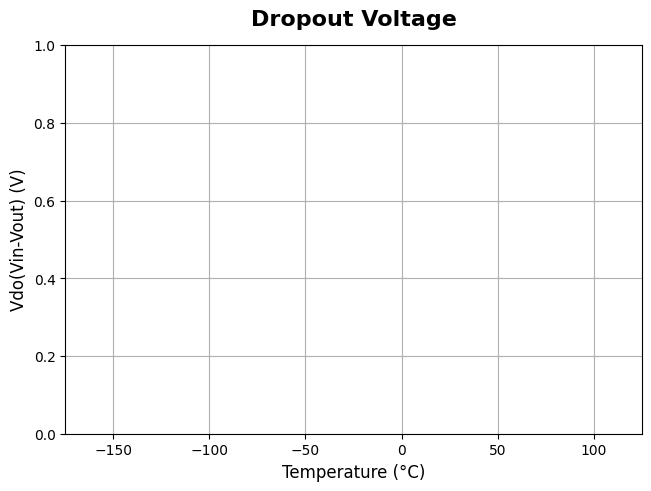

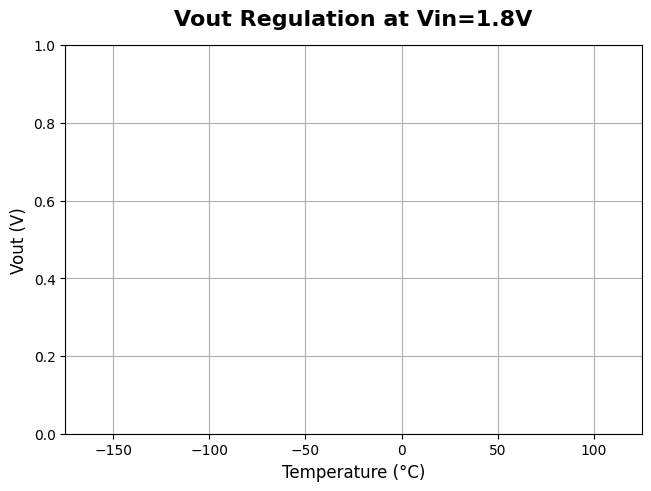

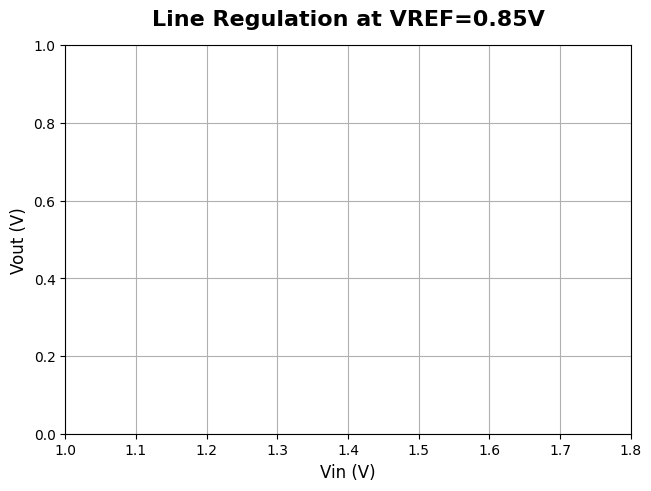

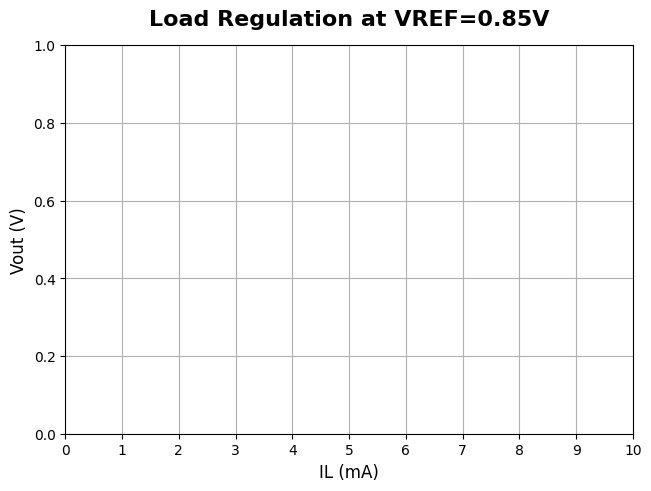

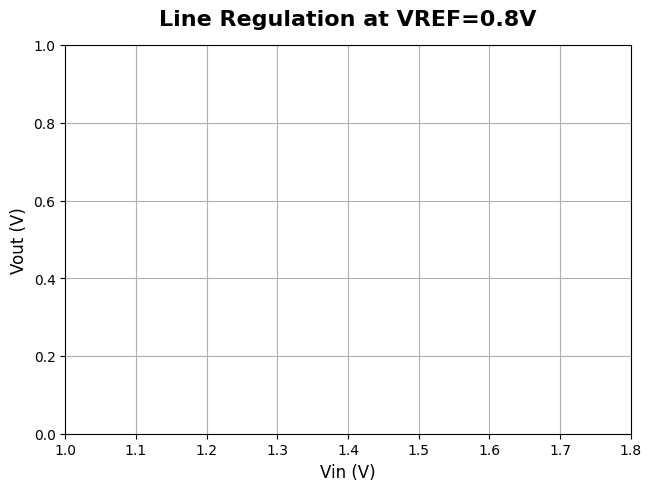

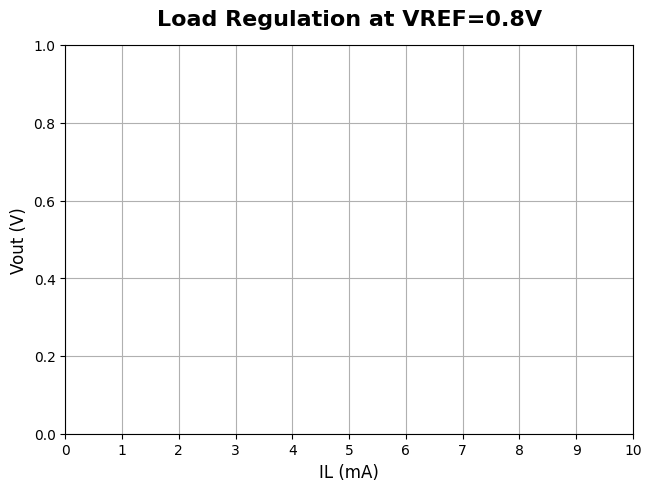

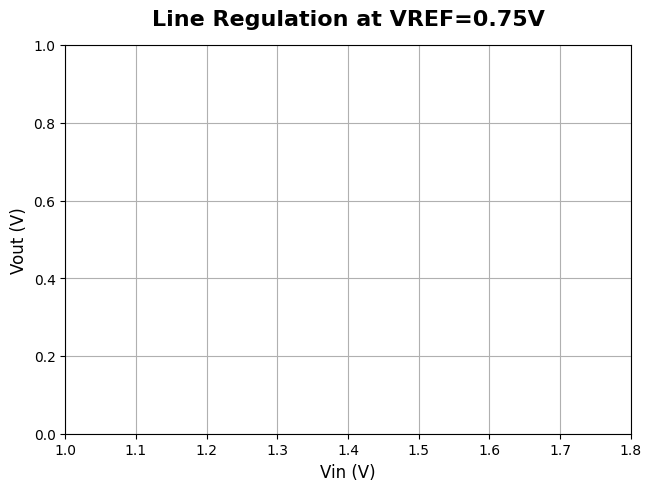

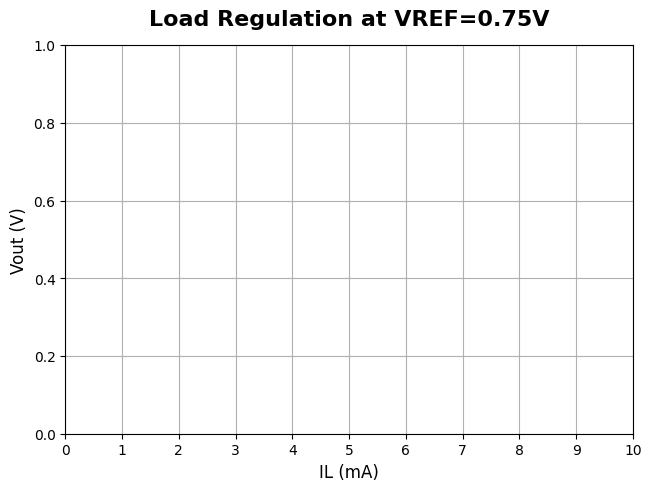

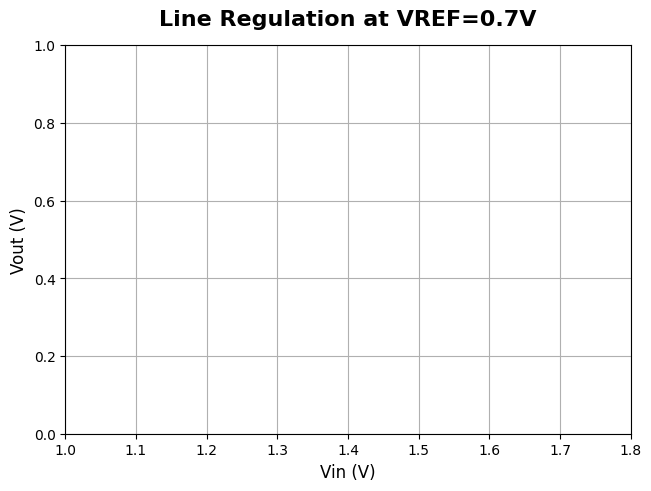

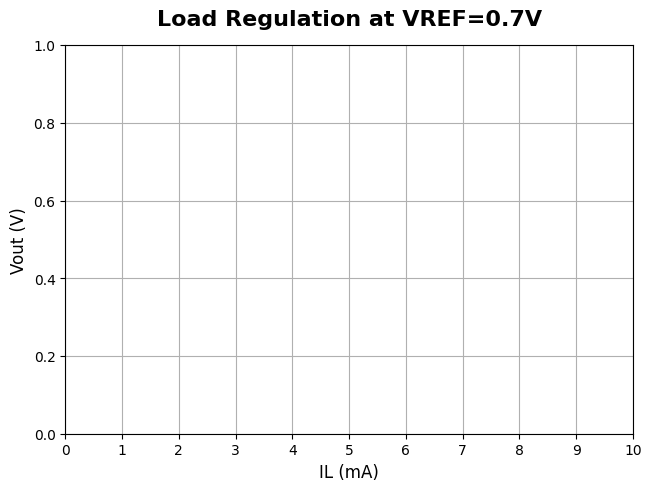

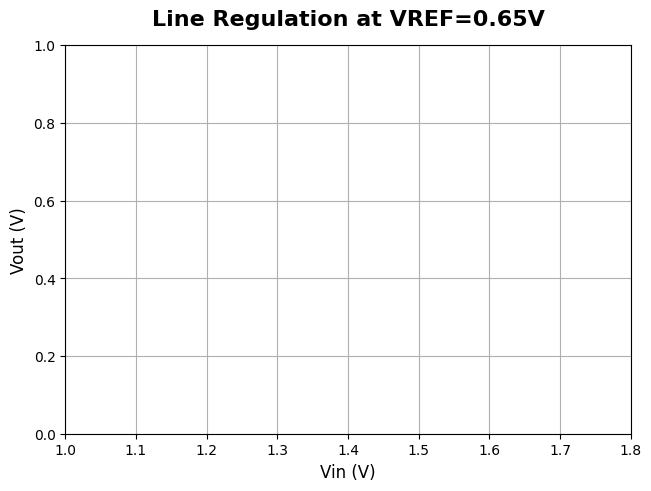

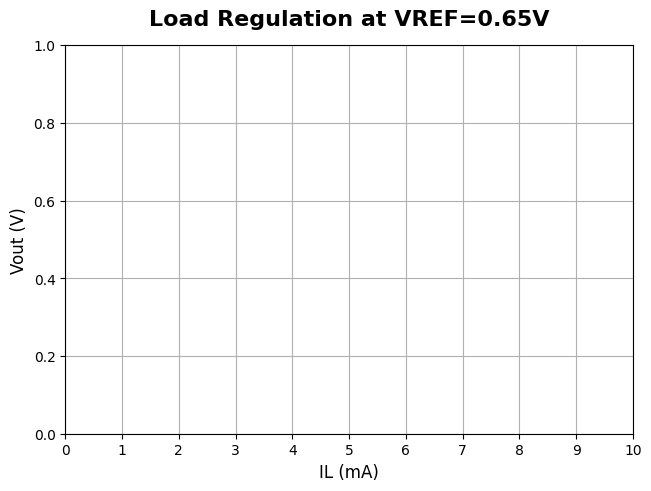

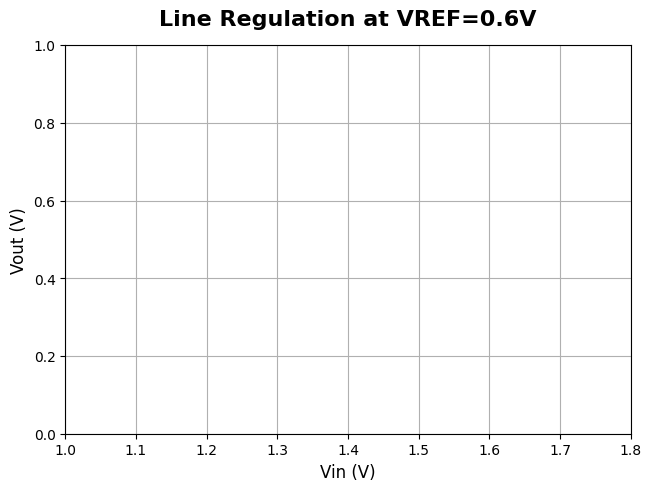

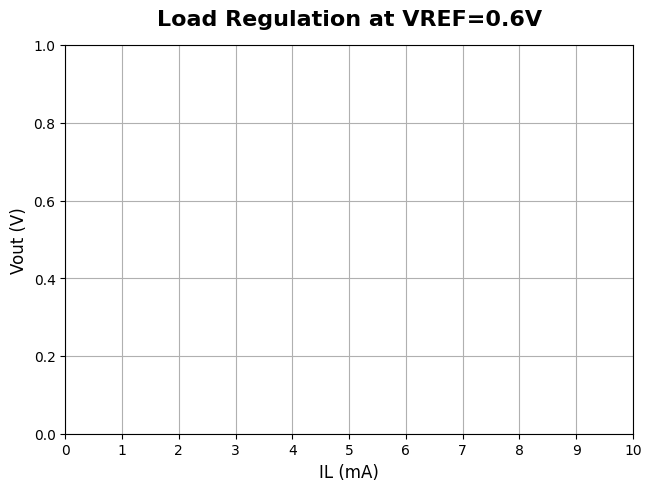

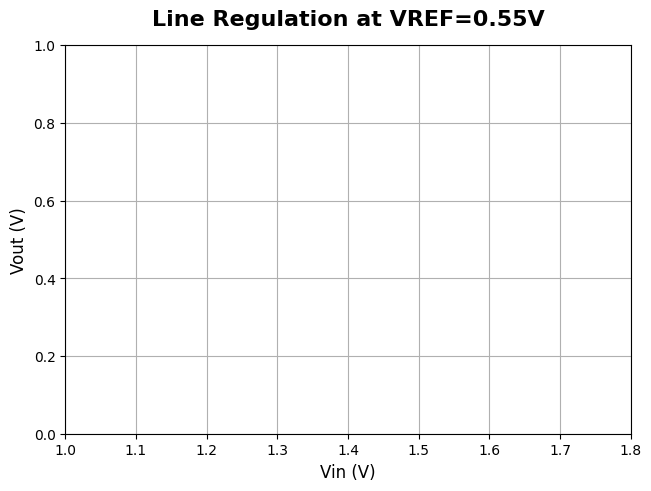

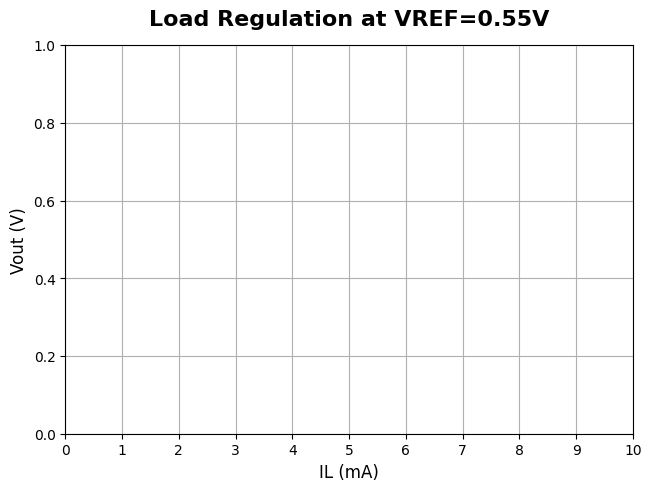

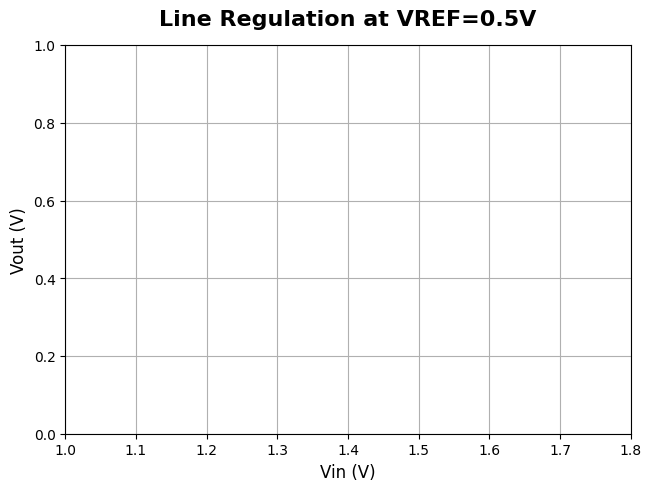

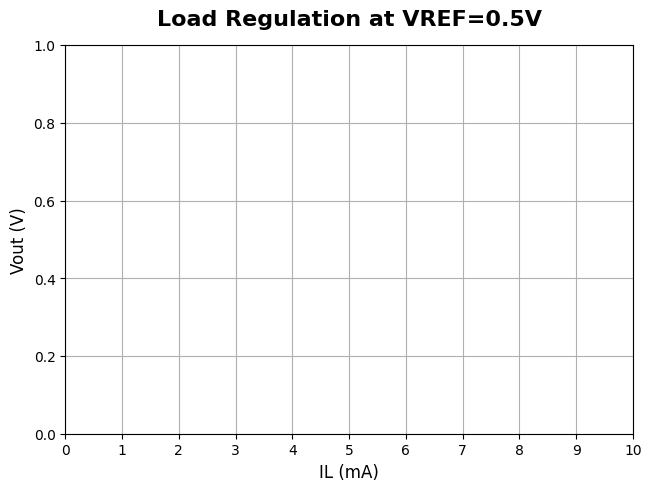

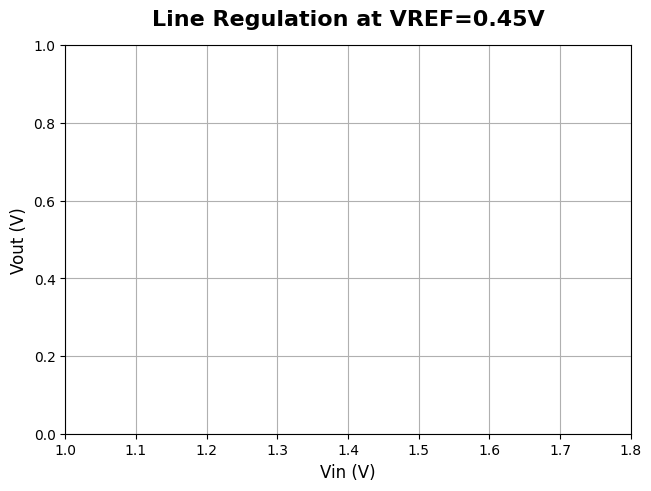

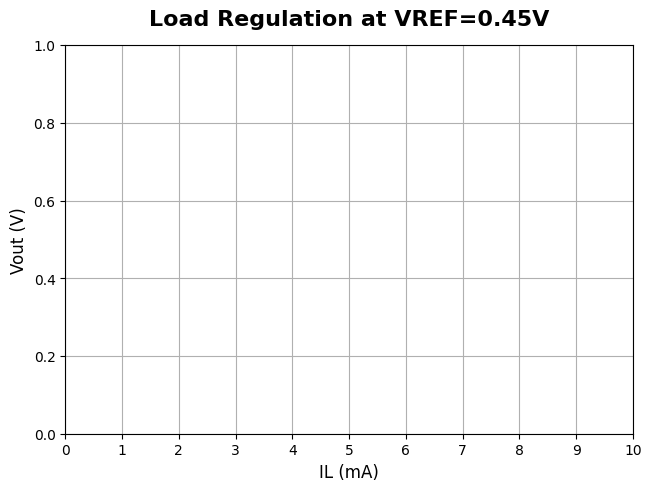

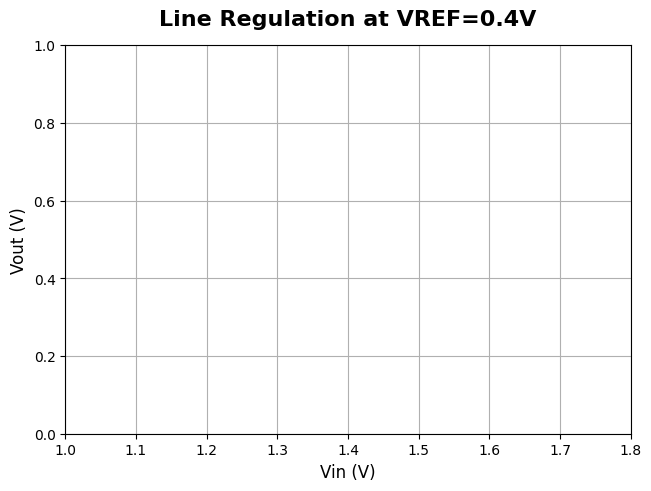

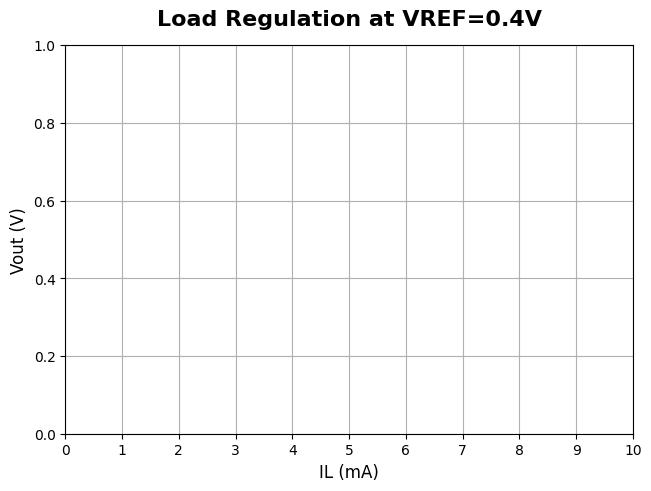

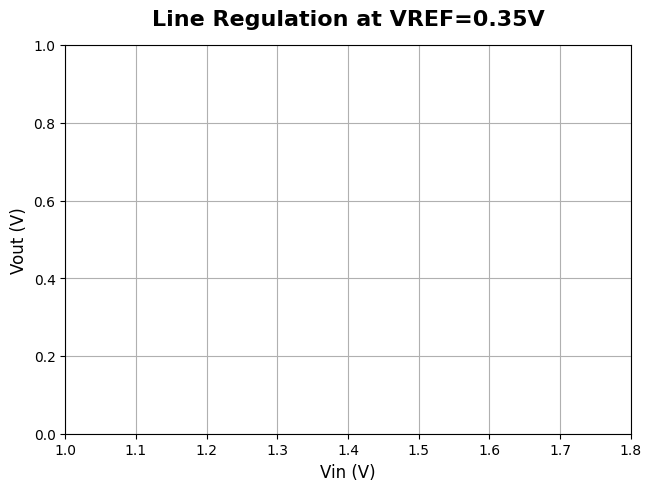

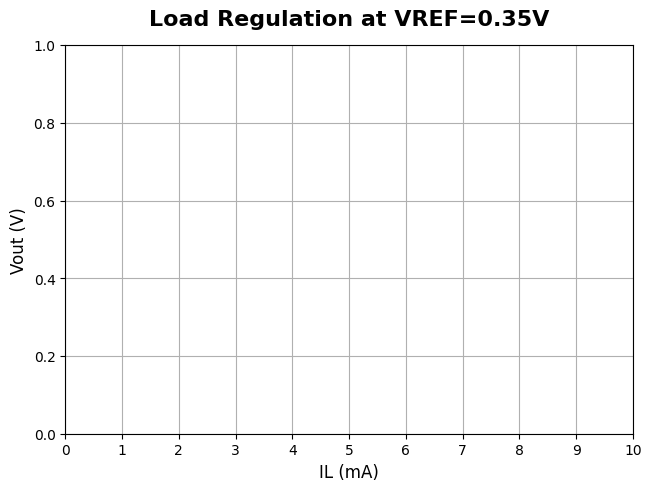

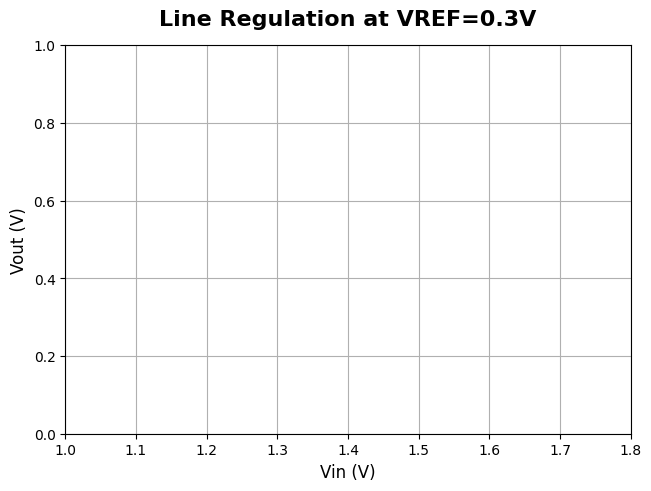

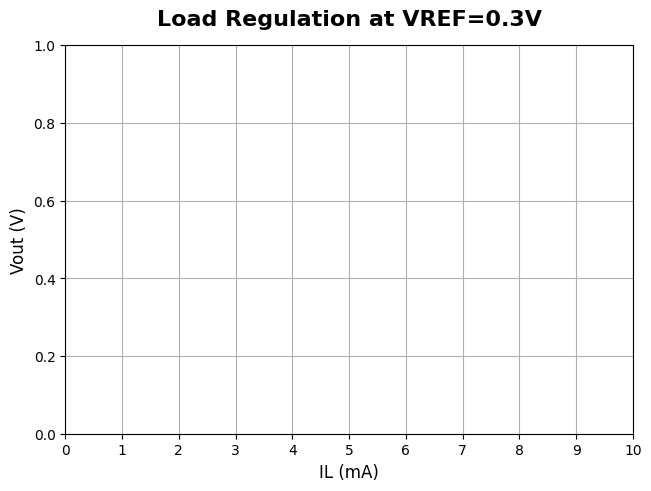

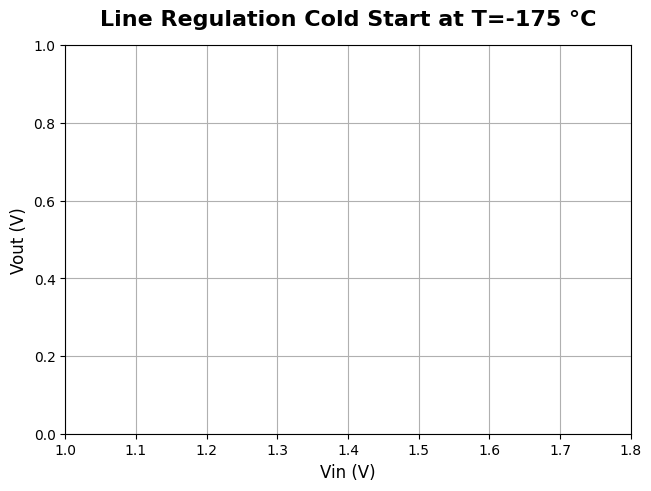

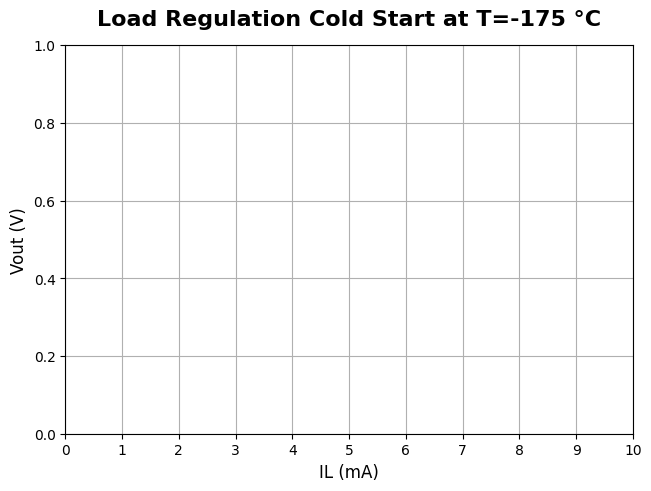

In [12]:
# Use this to print the formatting of all of your plots - don't call during tests
def Initialize_All_Plots():
    Dropout_Voltage_Plot_Init()
    Voltage_Regulation_Plot_Init()
    for VREF in Global_VREFs:
        Line_Regulation_Plot_Init(VREF)
        Load_Regulation_Plot_Init(VREF)
    Cold_Start_Line_Regulation_Plot_Init()
    Cold_Start_Load_Regulation_Plot_Init()
    plt.show()

Initialize_All_Plots()

<h3> Generate Plots from Saved Data</h3>

In [15]:
# Manual use - Not called during procedure

# Missing some results in this directory, so not all temps are included. 
#plot_temps = [125, 100, 75, 50, 25,  0, -25, -50, -75, -100, -125, -150, "-175C_Cold_Start"] # Manually set
plot_temps = temp_list
date = "2025-06-04" # Manually set 
run = "Experiment_1" # Manually set
read_dir = os.path.join(f"{DEVICE_NAME}_Results", date, run) 
write_dir = os.path.join(f"{DEVICE_NAME}_Results", date, run, "Plots_Generated_Later") # Make sure this doesn't overwrite anything important
os.makedirs(write_dir, exist_ok=True)

Plot_Across_Temps(read_dir, write_dir, plot_temps)

<h2> Experimental Procedure </h2>

<h3> Individual Test Definitions </h3>

In [2]:
def VISET_Calc(VREF, IL):
    VOUT = VREF*2
    return -Rhi*(IL-VOUT/Rlo)+VOUT

# Varies VREF. For each VREF, varies VIN, then IL. 
# Plots Line Regulation and Load Regulation.
# Records the VOUT corresponding to the largest VIN for the Voltage Regulation Plot
# Records calculated Dropout Voltage (from smallest VIN and corresponding VOUT) for the Dropout Voltage Plot
def VIN_Test(local):
    VISETs=[]
    VDOs=[]
    VOUTregs=[]
    for VREF in Global_VREFs:                                   
        ####### Sets VISET then VREF #######
        VISET = VISET_Calc(VREF, IL_default)
        VISETs.append(VISET)
        WG_VREF_VISET.write("SOUR2:APPL:DC DEF, DEF, " + str(VISET))   # Sets VISET to needed value to achieve default IL
        time.sleep(.1)                                                 # Set VISET before VREF because VREF is being swept up. Want to limit current
        WG_VREF_VISET.write("SOUR1:APPL:DC DEF, DEF, " + str(VREF))    # Sets VREF

        ####### Inner Sweeps #######
        VDO, VOUTreg = VIN_Test_Inner(VREF, local)    # Calls the VIN_Sweep function that sweeps VIN
        
        VDOs.append(VDO)
        VOUTregs.append(VOUTreg)   
        
    # Restore default VREF and VISET
    WG_VREF_VISET.write("SOUR1:APPL:DC DEF, DEF, " + str(VREF_default)) # VREF
    VISET = VISET_Calc(VREF_default, IL_default)            # Restores IL (with VISET)
    WG_VREF_VISET.write("SOUR2:APPL:DC DEF, DEF," + str(VISET))

    # Create an excel file with each VISET value used for each VREF
    df2 = pd.DataFrame({'VREF': Global_VREFs, 'VISET': VISETs, 'VDO': VDOs, 'VOUTreg': VOUTregs})
    csv_path = os.path.join(local, "VIN_Sweep_Overall") 
    df2.to_csv(csv_path, index=False)

#Called from VREF_Sweep for each VREF value, sweeps VIN.
def VIN_Test_Inner(VREF, local):
    ####### Creates Lists for Data #######              
    VINs=[]                                                  
    ITOTs=[] # Stores total current values (IQ + IL)
    VOUTs=[]                                                 
    VDROPs=[]

    ####### Sweep of VIN for default IL #######
    # VIN starts high at 1.8 V and then sweeps down to VIN_MIN or VREF, whichever is higher.                                        
    # Note: IL should already be at -10mA (ILMAX) so no changes are needed to VIN SENS range or VOUT SOURCE value    # No clue what this means -Shawn
    new_MIN = max(VIN_MIN, VREF)
    
    for val in np.arange(VIN_MAX, new_MIN+VIN_STEP, VIN_STEP):  # Loop from VIN_MAX to VIN_MIN (or VREF if its higher) in steps of VIN_STEP                                                            
        val = round(val,5)                                     
        ####### Sets VIN voltage #######            
        SM_VIN.write("SOUR:VOLT:LEV " + str(val))           # Set VIN
        time.sleep(.1)                                      # Pause for .5 seconds to allow the system to stabilize
        
        ####### Measure ILOAD and others #######
        VOUTs.append(float(MM_VOUT.query(":READ?")))     
        ITOTs.append(SM_VIN.query(":READ?").split(',')[1])   # Query and append the measured total current through VIN
        VDROPs.append(float(MM_VDROP.query(":READ?")))
        VINs.append(val)                                     # Append VIN to list
    SM_VIN.write("SOUR:VOLT:LEV 1.8") 

    ####### Store Data #######
    df = pd.DataFrame({'VIN': VINs, 'ITOT': ITOTs, 'VOUT': VOUTs, 'VDROP': VDROPs}) # Create a pandas DataFrame from VIN, ITOT, and VOUT lists
    csv_path = os.path.join(local, f"VIN_Sweep_VREF={VREF:.{VREF_precision}f}.csv")         # Generate the file path for saving the CSV
    df.to_csv(csv_path, index=False)                                            # Save the DataFrame to a CSV file without including the index
    
    VDO = VINs[-1] - VOUTs[-1]  # Calculate Dropout Voltage, to be used to generate plot.
    #VDO plot seems to be using the smallest VIN value (max of VIN_MIN, VREF-.1)
    
    return(VDO, VOUTs[0])

# Saves IL values and their Vout values for load regulation plot
def IL_Test(local):
    VISETlist = []
    for VREF in Global_VREFs:                                   
        ####### Sets VISET then VREF #######
        VISET = VISET_Calc(VREF, IL_default)
        VISETlist.append(VISET)
        WG_VREF_VISET.write("SOUR2:APPL:DC DEF, DEF, " + str(VISET))   # Sets VISET to needed value to achieve default IL
        time.sleep(.1)                                                 # Set VISET before VREF because VREF is being swept up. Want to limit current
        WG_VREF_VISET.write("SOUR1:APPL:DC DEF, DEF, " + str(VREF))    # Sets VREF
        
        ####### Creates Lists for Data #######               
        ITOTs=[]                                                 # Stores total current values (IQ + IL)
        VOUTs=[]                                                
        VDROPs=[]
        for IL in ILlist:
            VISET = VISET_Calc(VREF, IL)
            WG_VREF_VISET.write(f"SOUR2:APPL:DC DEF, DEF, {VISET}")
            time.sleep(.1)
            VOUTs.append(float(MM_VOUT.query(":READ?")))     
            ITOTs.append(SM_VIN.query(":READ?").split(',')[1])   # Not used for any plots yet, saved anyways
            VDROPs.append(float(MM_VDROP.query(":READ?")))       # Not used for any plots yet, saved anyways
        VISET = VISET_Calc(VREF, IL_default)
        WG_VREF_VISET.write(f"SOUR2:APPL:DC DEF, DEF, {VISET}")
        time.sleep(1) # Source gets stuck at previous current, hopefully this will solve that.
        
        ####### Store Data #######
        df = pd.DataFrame({'IL': ILlist, 'ITOT': ITOTs, 'VOUT': VOUTs, 'VDROP': VDROPs}) # Create a pandas DataFrame from lists
        csv_path = os.path.join(local, f"IL_Sweep_VREF={VREF:.{VREF_precision}f}.csv")                      
        df.to_csv(csv_path, index=False)
        

<h3> Full Procedure Definition </h3>

In [ ]:
#####################################################################################################################
################## IMPORTANT: Make sure all CHAMBER commands are contained with an if(UseChamber): ##################
#####################################################################################################################

# UseChamber = True - turns on the temperature chamber and performs the temperature sweep
# UseChamber = False - performs a test run without the chamber.

def Run_Experiment(UseChamber, RUN_TYPE, p_temp=27):
    # Create file path
    DATE_DIR =  str(date.today())
    i = 1
    RUN_DIR =  os.path.join(f"{DEVICE_NAME}_Results", f"{DATE_DIR}", f"{RUN_TYPE}_{i}")
    while (os.path.isdir(RUN_DIR) == True) and (len(os.listdir(RUN_DIR)) != 0) : # Checks if directory name is taken, updates run number until it is not. Makes sure directory isn't empty.
        i = i+1
        RUN_DIR =  os.path.join(f"{DEVICE_NAME}_Results", f"{DATE_DIR}", f"{RUN_TYPE}_{i}")           
    os.makedirs(RUN_DIR, exist_ok=True)  # If the directory already exists, it won't raise an error due to exist_ok=True
    
    ################## Initialize Equipment ##################
    
    if (UseChamber):
        Chamber_INIT()
    initialize_all() 
    turn_on_all()
    
    ################## Temperature Sweep ##################
    
    temps_tested = []
    if (UseChamber):
        temps_to_test = temp_list
    else:
        temps_to_test = [p_temp]
        
    for temp in temps_to_test:
        TEMP_DIR=f"{RUN_DIR}/TEMP_{temp}"                # The temperature of the experiment gets set as the sub directory name
        os.makedirs(TEMP_DIR, exist_ok=True)             # Create a directory with the given name. If the directory already exists, it won't raise an error due to exist_ok=True

        if (UseChamber):    
            CHAMBER.write("WAIT=1")                      # Resets the wait time of the temp chamber to 30 minutes so it doesn't time out mid test
            CHAMBER.write(f"SET={temp}")
            while (CHAMBER.query("STATUS?")[3] == 'N'):  # Checks if the temperature chamber has arrived at temp yet or not
                time.sleep(10)
                measure_all()
                #print(CHAMBER.query("STATUS?"))
            CHAMBER.write("WAIT=FOREV")
            # while(True):
            #     time.sleep(10)
            #     measure_all()
            #     user_probe_temp = CHAMBER.query("USER?")
            #     if ((user_probe_temp < temp+SET_PRECISION) and (user_probe_temp > temp-SET_PRECISION)):
            #         break
            print(CHAMBER.query("STATUS?"))
            time.sleep(300)                              # Soak time

        VIN_Test(TEMP_DIR)
        IL_Test(TEMP_DIR)

        temps_tested.append(temp)
        Plot_Across_Temps(RUN_DIR, RUN_DIR, temps_tested) # Intermediate plots

    Plot_Across_Temps(RUN_DIR, RUN_DIR, temps_to_test)     # Overall plots

    ##################### Cold Start #####################
    
    turn_off_all()       # Turn off voltages
    if (UseChamber):
        time.sleep(900)  # Wait 15 minutes for device to cool down
    else:
        time.sleep(5)    # I feel like it's a bad idea to rapidly turn everything off then on, so here's a short wait
    turn_on_all()

    TEMP_DIR_CS = f"{RUN_DIR}/TEMP_-175C_Cold_Start"
    os.makedirs(TEMP_DIR_CS, exist_ok=True)
    
    VIN_Test(TEMP_DIR_CS)
    IL_Test(TEMP_DIR_CS)
    
    Plot_Cold_Start(RUN_DIR, RUN_DIR)

    turn_off_all()       # Temperature Chamber is NOT off at this point. Close valve, let the pipes empty, then set it back to room temp.


<h2> Inputs for Running Experiment</h2>

In [ ]:
turn_on_all()

In [ ]:
measure_all()

In [ ]:
#You'll need to run this every time you stop mid-test
turn_off_all()

In [ ]:
# Manually change this. For labelling purposes. Doesn't actually set a temperature.
practice_temperature = "27"

# PRACTICE Run, chamber not affected
Run_Experiment(False, f"Practice_Run_{practice_temperature}°C", p_temp=practice_temperature)

In [ ]:
#
#
# Buffer so we don't misclick
#
#

In [ ]:
# ACTUAL Run, chamber sweeps temperature

# CHAMBER TURNS ON
Run_Experiment(True, "Experiment") # CHAMBER TURNS ON
# CHAMBER TURNS ON